In [49]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
rc('font', family='serif', weight='ultralight')
rc('figure', facecolor='w')
from astropy.io import fits, ascii
from astropy.table import Table
from collections import OrderedDict
from scipy.interpolate import UnivariateSpline
import os
import math
from natsort import natsorted as nsort

import TheCannon
from TheCannon import apogee, dataset, model
import apogee_tools as ap
AP_PATH = os.environ['APOGEE_DATA']

line_list = ap.lines
line_names = line_list.keys()

In [22]:
dfile = AP_PATH + '/training_sets/west_sample_cut/'
rfile = '../train_ref/west_ref_labels.csv'  

ids, wl, tr_flux, tr_ivar = apogee.load_spectra(dfile)
tr_ID = np.array([x.split('2-')[1].split('.fits')[0] for x in ids])
tr_label = ap.loadLabels(rfile, lbl_names=['SPT'])
# tr_label = ap.scaleLabels(ap.loadLabels(rfile, lbl_names=['TEFF', 'FE_H']))

wave = ap.rvShift(wl, rv=-80)
ds = dataset.Dataset(wave, tr_ID, tr_flux, tr_ivar, tr_label, tr_ID, tr_flux, tr_ivar)
ds.set_label_names(['SPT'])
ds.tr_label.shape, ds.tr_ID.shape, ds.tr_flux.shape, ds.tr_ivar.shape

bands = [[15150,15800],[15865,16425],[16480,16945]]
pbands = [np.where((ds.wl > bands[0][0]) & (ds.wl < bands[0][1]))[0], \
    np.where((ds.wl > bands[1][0]) & (ds.wl < bands[1][1]))[0], \
    np.where((ds.wl > bands[2][0]) & (ds.wl < bands[2][1]))[0]]

This is the right version
Loading spectra from directory /home/jess/Desktop/Research/data/apogee_data/training_sets/west_sample_cut/
Spectra loaded


In [15]:
md, ds, synth = ap.fitCannonModel(ds)
np.save('cross_validation/model_coeff_fullset', md.coeffs)

Done training model. 
Inferring Labels


In [50]:
ds.diagnostics_1to1()

Diagnostic for label output vs. input
Saved fig 1to1_label_0.png


In [53]:
# trn_labels, tst_labels, crv_labels = ap.crossValidate(ds, save_dir='cross_validation/', lbl_names=['SPT'])

In [16]:
# np.save('cross_validation/trn_labels', trn_labels)
# np.save('cross_validation/tst_labels', tst_labels)
# np.save('cross_validation/crv_labels', crv_labels)

trn_labels = np.load('cross_validation/trn_labels.npy')
tst_labels = np.load('cross_validation/tst_labels.npy')
crv_labels = np.load('cross_validation/crv_labels.npy')

In [17]:
trn_spt = np.array(trn_labels).T[0]
tst_spt = np.array(tst_labels).T[0]
crv_spt = np.array(crv_labels).T[0]

tst_spt_err = trn_spt - tst_spt 
crv_spt_err = trn_spt - crv_spt 
spt_tst_crv_diff = tst_spt - crv_spt

#=========

def chi_sq(data, model, ivar):
    chi = []
    for i in range(len(data)):
        chi.append(np.sum(ivar[i]*(data[i]-model[i])**2))
    return np.array(chi)

chi = chi_sq(ds.tr_flux, synth, ds.tr_ivar)

crv_files = nsort(os.listdir('cross_validation/crv_flux/'))
crv_fls = np.array([np.load('cross_validation/crv_flux/' + f) for f in crv_files])
crv_chi = chi = chi_sq(ds.tr_flux, crv_fls, ds.tr_ivar)

In [18]:
d = {'ID':tr_ID, 'TRAIN_SPT':np.round(trn_spt,1), 'TEST_SPT':np.round(tst_spt,1), 'CROSS_SPT':np.round(crv_spt,1), \
     'CHI_SQ':chi}

# rcont = pd.read_csv(rfile)
# conv_index = np.array([np.where(rcont['ID'] == s)[0][0] for s in ds.tr_ID])
# ra_ordered = rcont['RA'][conv_index]
# dec_ordered = rcont['DEC'][conv_index]

# d = {'ID':tr_ID, 'RA':np.round(ra_ordered,5), 'DEC':np.round(dec_ordered,5), 'TRAIN_SPT':np.round(trn_spt,1), \
#      'TEST_SPT':np.round(tst_spt,1), 'CROSS_SPT':np.round(crv_spt,1), 'CHI_SQ':chi}

df = pd.DataFrame(data=OrderedDict(d))
df.to_csv('results/test_results.csv', index=None)

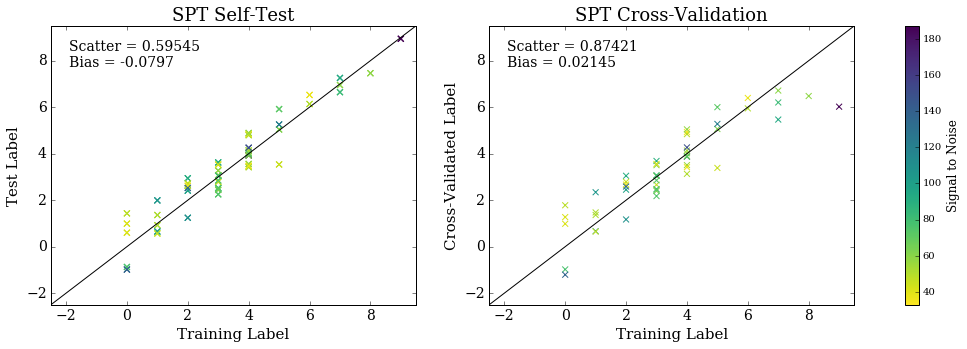

In [51]:
x = np.arange(-10,15)
scat1, bias1 = np.round(np.std(tst_spt_err),5), np.round(np.mean(tst_spt_err),5)
text1 = 'Scatter = %s \nBias = %s'%(scat1, bias1)
scat2, bias2 = np.round(np.std(crv_spt_err),5), np.round(np.mean(crv_spt_err),5)
text2 = 'Scatter = %s \nBias = %s'%(scat2, bias2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[18,5])
pl = ax1.scatter(trn_spt, tst_spt, marker='x', c=ds.test_SNR, s=35, cmap='viridis_r')

ax1.scatter(trn_spt, tst_spt, c=ds.test_SNR, marker='x', s=35, cmap='viridis_r')
ax1.text(0.05, 0.95, text1, fontsize=14, transform=ax1.transAxes, verticalalignment='top')
ax1.plot(x,x, color='k')
ax1.set_xlim(-2.5,9.5)
ax1.set_ylim(-2.5,9.5)
ax1.set_xlabel('Training Label', fontsize=15)
ax1.set_ylabel('Test Label', fontsize=15)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('SPT Self-Test', fontsize=18)

ax2.scatter(trn_spt, crv_spt, c=ds.test_SNR, marker='x', s=35, cmap='viridis_r')
ax2.text(0.05, 0.95, text2, fontsize=14, transform=ax2.transAxes, verticalalignment='top')
pl = ax1.scatter(trn_spt, tst_spt, marker='x', c=ds.test_SNR, s=35, cmap='viridis_r')

ax2.plot(x,x, color='k')
ax2.set_xlim(-2.5,9.5)
ax2.set_ylim(-2.5,9.5)
ax2.set_xlabel('Training Label', fontsize=15)
ax2.set_ylabel('Cross-Validated Label', fontsize=15)
ax2.set_title('SPT Cross-Validation', fontsize=18)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
cb.set_label('Signal to Noise', fontsize=12)
plt.savefig('results/self_and_validation_test_spt_snr.png')
plt.show()

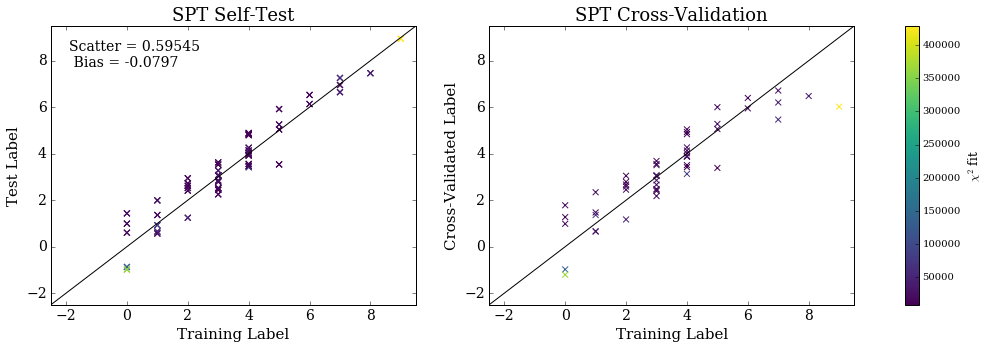

In [33]:
x = np.arange(-10,15)
scat1, bias1 = np.round(np.std(tst_spt_err),5), np.round(np.mean(tst_spt_err),5)
text1 = 'Scatter = %s \n Bias = %s'%(scat1, bias1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[18,5])
pl = ax1.scatter(trn_spt, tst_spt, marker='x', c=chi, s=35, cmap='viridis')

ax1.scatter(trn_spt, tst_spt, c=chi, marker='x', s=35, cmap='viridis')
ax1.text(0.05, 0.95, text1, fontsize=14, transform=ax1.transAxes, verticalalignment='top')
ax1.plot(x,x, color='k')
ax1.set_xlim(-2.5,9.5)
ax1.set_ylim(-2.5,9.5)
ax1.set_xlabel('Training Label', fontsize=15)
ax1.set_ylabel('Test Label', fontsize=15)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('SPT Self-Test', fontsize=18)

ax2.scatter(trn_spt, crv_spt, c=crv_chi, marker='x', s=35, cmap='viridis')
pl = ax1.scatter(trn_spt, tst_spt, marker='x', c=chi, s=35, cmap='viridis')

ax2.plot(x,x, color='k')
ax2.set_xlim(-2.5,9.5)
ax2.set_ylim(-2.5,9.5)
ax2.set_xlabel('Training Label', fontsize=15)
ax2.set_ylabel('Cross-Validated Label', fontsize=15)
ax2.set_title('SPT Cross-Validation', fontsize=18)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
cb.set_label(r'$\chi^{2}$ fit', fontsize=12)
plt.savefig('results/self_and_validation_test_spt_chisq.png')
plt.show()

In [72]:
N = tr_label.shape[0]
coeff_n = np.array([np.load('cross_validation/model_coeff/model_coeff_'+str(i)+'.npy') for i in range(N)])
coeff_full = np.load('cross_validation/model_coeff_fullset.npy')

def jackknife(l,m):
    
    diff_sq = 0
    for n in range(N): #star
        diff_sq += (coeff_n[n][m][l] - coeff_full[m][l])**2
    
    s = (N-1)/N * diff_sq 
    
    return math.sqrt(s)

npix = len(ds.wl)
jack_err_spt = np.array([jackknife(1,m) for m in range(npix)])

## Spectral sequence plots:

0 2M19210112+3742134
1 2M03114974+0115158
2 2M16363188+3655364
3 2M12492657-0312032
4 2M12203634+2505351
5 2M14030704+5403356
6 2M11203609+0704135
7 2M03122509+0021585
8 2M11194647+0820356
9 2M15010818+2250020


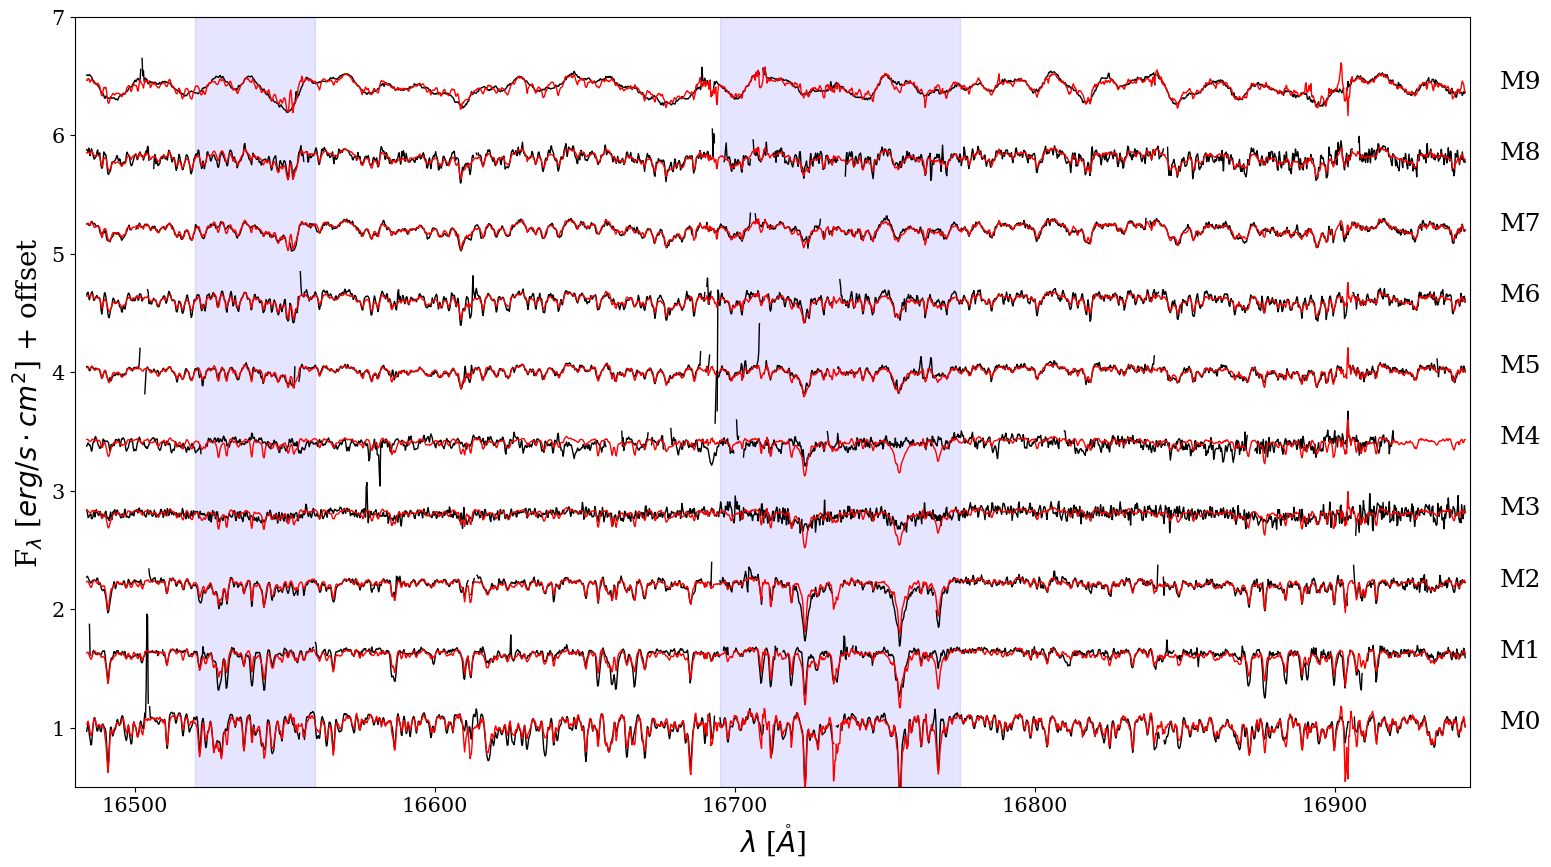

In [42]:
b = 2
seq_ind = [np.where(chi == max(chi[np.where(ds.tr_label.T[0] == c)[0]]))[0][0] for c in np.arange(10)]

highlights = [[15290,15350],[15530,15590],[15620,15650],[15715,15780], \
               [15960,15980],[16150,16220], \
               [16520,16560],[16695,16775]]

plt.style.use('default')
rc('font', family='serif')
plt.figure(figsize=[18,10])

for i in range(10):
    print(i, ds.tr_ID[seq_ind[i]])
    dflux = ds.tr_flux[seq_ind[i]] + .6*i
    mflux = synth[seq_ind[i]] + .6*i

    dflux[ds.tr_flux[seq_ind[i]] == 0] = np.nan
    mflux[synth[seq_ind[i]] == 0] = np.nan
    
    plt.plot(wl, dflux, color='k', linewidth=1)
    plt.plot(wl, mflux, color='r', linewidth=1)
    plt.text(bands[b][1]+10, np.nanmean(mflux), 'M'+str(i), fontsize=18)
    if b == 0:
        plt.text(bands[b][0]+10, np.nanmean(mflux)+.22, ds.tr_ID[seq_ind[i]])
    
for h in highlights:
    plt.axvspan(h[0], h[1], color='b', alpha=0.1)
    
if b == 0:
    plt.title('APOGEE Spectral Sequence', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel(r'F$_{\lambda}$ [$erg/s \cdot cm^{2}$] + offset', fontsize=20)
plt.xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=20)
plt.xlim(bands[b])
plt.ylim(.5,7)
# plt.tight_layout()
plt.savefig('results/Spectral_Sequence_' + str(b+1) + '.png')
plt.show()
plt.style.use('classic')

## 3 bands of derivatives:

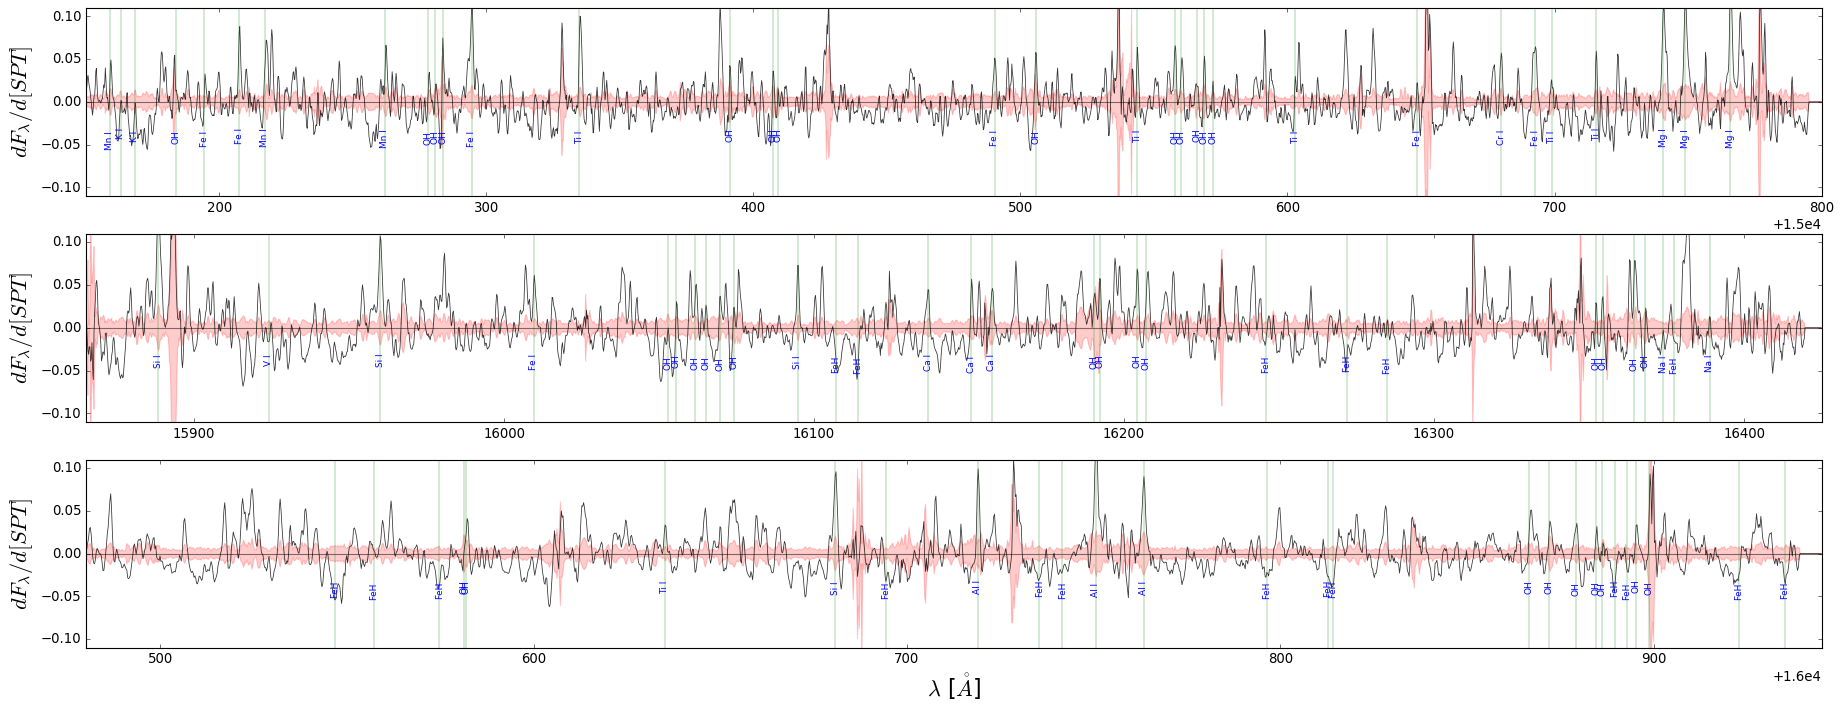

In [97]:
k = 1
wave = ds.wl
flux = md.coeffs.T[k]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(28,10), facecolor='w', sharey=True)

ax1.plot(ds.wl[pbands[0]], md.coeffs.T[k][pbands[0]], color='k', alpha=.8, linewidth=.7)
ax1.fill_between(ds.wl, -jack_err_spt, jack_err_spt, alpha=.2, color='r')
ax1.axhline(y=0, color='k', alpha=.5)
ax1.set_ylabel(r'$dF_{\lambda}/d[SPT]$', fontsize=20)
ax1.set_xlim(bands[0])

ax2.plot(ds.wl[pbands[1]], md.coeffs.T[k][pbands[1]], color='k', alpha=.8, linewidth=.7)
ax2.fill_between(ds.wl, -jack_err_spt, jack_err_spt, alpha=.2, color='r')
ax2.axhline(y=0, color='k', alpha=.5)
ax2.set_ylabel(r'$dF_{\lambda}/d[SPT]$', fontsize=20)
ax2.set_xlim(bands[1])

ax3.plot(ds.wl[pbands[2]], md.coeffs.T[k][pbands[2]], color='k', alpha=.8, linewidth=.7)
ax3.fill_between(ds.wl, -jack_err_spt, jack_err_spt, alpha=.2, color='r')
ax3.axhline(y=0, color='k', alpha=.5)
ax3.set_ylabel(r'$dF_{\lambda}/d[SPT]$', fontsize=20)
ax3.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=20)
ax3.set_xlim(bands[2])

xrange = [ds.wl[0], ds.wl[1]]
yrange = [min(md.coeffs.T[k]), max(md.coeffs.T[k])]

for lines in line_names:
    for feature in line_list[lines]:

        # determine position of the line and label based on pixel of the spectrum
        xpos = min(wave, key=lambda x:abs(x - feature))
        index = list(wave).index(xpos)
        ypos = flux[index]

        if (feature >= bands[0][0]) & (feature <= bands[0][1]):
            ax1.axvline(x=feature, ymin=-1, ymax=1, linewidth=.3, color='g')
            ax1.text(feature, -.04+np.random.uniform(-.002,.002), lines, rotation=90, ha='center', color='b', fontsize=8)
       
        elif (feature >= bands[1][0]) & (feature <= bands[1][1]):
            ax2.axvline(x=feature, ymin=-1, ymax=1, linewidth=.3, color='g')
            ax2.text(feature, -.04+np.random.uniform(-.002,.002), lines, rotation=90, ha='center', color='b', fontsize=8)

        elif (feature >= bands[2][0]) & (feature <= bands[2][1]):
            ax3.axvline(x=feature, ymin=-1, ymax=1, linewidth=.3, color='g')
            ax3.text(feature, -.04+np.random.uniform(-.002,.002), lines, rotation=90, ha='center', color='b', fontsize=8)

    
plt.ylim(-.11,.11)
plt.savefig('results/derivative_jackknife_spt.png')
plt.show()

## Plot entire training set with Cannon models:

In [98]:
n = 1 #band 1, 2, 3
plotCannonModels(ds, synth, tst_labels, save=True, out='results/Models_Band'+str(n)+'.pdf', base='West', \
                 tr_lbl_unc=[1], te_lbl_unc=[1.2], snr=ds.test_SNR, band=n)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [95]:
for n in [1,2,3]:
    plotCannonModels(ds, synth, tst_labels, save=True, out='results/Models_Band'+str(n)+'.pdf', base='West', \
                 tr_lbl_unc=[1], te_lbl_unc=[1.2], snr=ds.test_SNR, band=n)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [94]:
def plotCannonModels(ds, te_flux, te_labels, **kwargs):

    bands  = [[15160,15800],[15880,16420],[16500,16935]]
    n      = kwargs.get('band', 1)
    yrange = kwargs.get('yrange', [.6,1.2])
    base   = kwargs.get('base', 'Ref')
    lbl_names = kwargs.get('lbl_names', ['SPT'])
    sigfig = kwargs.get('sigfig', [1 for x in lbl_names])
    snr = kwargs.get('snr', [])
    
    save = kwargs.get('save', False)
    out  = kwargs.get('out', 'Models_Band'+str(n)+'.pdf')
    
    nspecs = len(te_flux)
    nparam = len(lbl_names)

    nplots = kwargs.get('nplots', nspecs)
    
    tr_label = ds.tr_label
    tr_label_unc = kwargs.get('tr_lbl_unc')
    te_label = te_labels
    te_label_unc = kwargs.get('te_lbl_unc', [0,0])
    
    wl = ds.wl
    tr_flux = ds.tr_flux
    tr_ivar = ds.tr_ivar
    
    fig, axs = plt.subplots(nplots, 1, figsize=(16,4*nspecs))
    for i, ax in enumerate(fig.axes):

        tr_stdev = [1/math.sqrt(ivar) for ivar in tr_ivar[i]]
    
#         data = ap.Spectrum(wave=wl, flux=tr_flux[i], sigmas=tr_stdev)
#         mdl  = ap.Spectrum(wave=wl, flux=te_flux[i])
#         chi  = ap.compareSpectra(data, mdl, fit_scale=False)[0]
        
        ax.plot(wl, tr_flux[i], color='k', linewidth=1)
        ax.plot(wl, te_flux[i], color='r', linewidth=1)
        
        par_str1 = [r'${} = {} \pm {}$'.format(lbl_names[k], round(te_label[i][k],sigfig[k]), te_label_unc[0]) for k in range(nparam)]
        can_lbl  = r'$Cannon: $ {}'.format(', '.join(par_str1))
        ax.text(bands[n-1][0]+10, yrange[1]-.08, can_lbl, color='r', fontsize=15, va='bottom', ha='left')

        par_str2 = [r'${} = {} \pm {}$'.format(lbl_names[k], round(tr_label[i][k],sigfig[k]), tr_label_unc[0]) for k in range(nparam)]
        ref_lbl  = r'${}: $ {}'.format(base, ', '.join(par_str2))
        ax.text(bands[n-1][0]+10, yrange[0]+.08, ref_lbl, color='k', fontsize=15, va='top', ha='left')
        
        chi_lbl = r'$\chi^{2} = %s$'%(str(chi[i]))
        ax.text(bands[n-1][1]-10, yrange[1]-.08, chi_lbl, color='r', fontsize=15, va='bottom', ha='right')
        
        if len(snr) != 0:
            snr_lbl = r'$SNR = {}$'.format(str(round(snr[i],1)))
            ax.text(bands[n-1][1]-10, yrange[0]+.08, snr_lbl, color='k', fontsize=15, va='top', ha='right')
         
        ax.set_title(r'${}$'.format(ds.tr_ID[i]), fontsize=20)
        ax.set_xlim(bands[n-1])
        ax.set_ylim(yrange)
        ax.set_ylabel(r'$F_{\lambda}$ [$erg/s \cdot cm^{2}$]', fontsize=15)
        if i == nspecs-1:
            ax.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=15)
    
    plt.tight_layout()
    if save == True:
        plt.savefig(str(out))
    plt.show()
    plt.close()

In [13]:
np.arange(1, 30, 2)

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])

In [31]:
mdl = ap.getModel(params=[3500, 5.0, 0.0], grid='PHOENIX', xrange=[15200,16940])

PHOENIX: [3500, 5.0, 0.0]


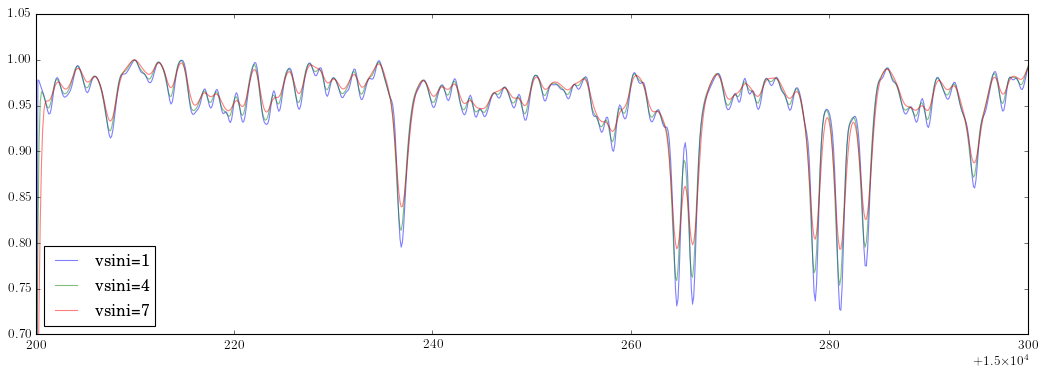

In [42]:
plt.figure(figsize=[16,5])
for vel in np.arange(1,10,3):
    broad_sp = ap.applyVsini(mdl, vsini=vel)
    broad_sp.flux = broad_sp.flux/max(broad_sp.flux)
    plt.plot(broad_sp.wave, broad_sp.flux, alpha=.5, linewidth=1, label='vsini='+str(vel))
plt.legend(loc='lower left')
plt.xlim(15200, 15300)
plt.ylim(.7, 1.05)
plt.show()

In [36]:
mdl.wave

array([15200.10937208, 15200.23132128, 15200.35327146, ...,
       16939.69510952, 16939.83101527, 16939.96692211])

In [46]:
len(ds.tr_SNR)

51